### Import helper functions

In [4]:
from plot_helpers import show_image, plot_results, scatter
from dataset_helpers import reshape, dataset_split, filenames_to_labels, resize_images, images_to_dataset
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
imw = 192
imh = 192
c = 1
RS = 2211

### Read dataset

In [5]:
## DON'T NEED TO RUN THIS ALL THE TIME!
# resize_images()

In [6]:
dataset, filenames = images_to_dataset(w=imw, h=imh)

All files formatted into dataset.


In [7]:
labels, DMSO = filenames_to_labels(filenames)

In [8]:
DMSO_dataset = np.ndarray(shape=(len(DMSO), imw, imh), dtype=np.float32)
DMSO_labels = []
i = 0
for index in DMSO:
    DMSO_dataset[i] = dataset[index]
    DMSO_labels.append(labels[index])
    i += 1

In [9]:
x_dmso = np.reshape(DMSO_dataset, (len(DMSO_dataset), imw, imh, 1))

In [10]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)
#x_train, x_valid, y_train, y_valid = dataset_split(x_train, y_train, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), imw, imh, 1))
#x_valid = np.reshape(x_valid, (len(x_valid), imw, imh, 1))
x_test = np.reshape(x_test, (len(x_test), imw, imh, 1))

In [189]:
def pairup(imgs, labels):
    idx = 0
    y = 0
    pairs = np.ndarray(shape=(len(imgs)//2, imw, imh, 3), dtype=np.float32)
    pairs_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        if labels[idx] != labels[idx+1]:
            raise("There is a label issue at %d" %idx)
        pairs[y, :, :, 1] = tcell
        pairs[y, :, :, 2] = dcell
        pairs_labels.append(labels[idx])
        idx += 2
        y += 1
    return pairs, pairs_labels

x_pair, y_pair = pairup(dataset, labels)

### Image augmentation

In [55]:
from keras.preprocessing.image import ImageDataGenerator

In [56]:
# create data generator
datagen = ImageDataGenerator()

# iterate through dataset already in memory
it = datagen.flow(x_train, y_train)

In [77]:
dataset.shape
x_train.shape

(1668, 192, 192, 1)

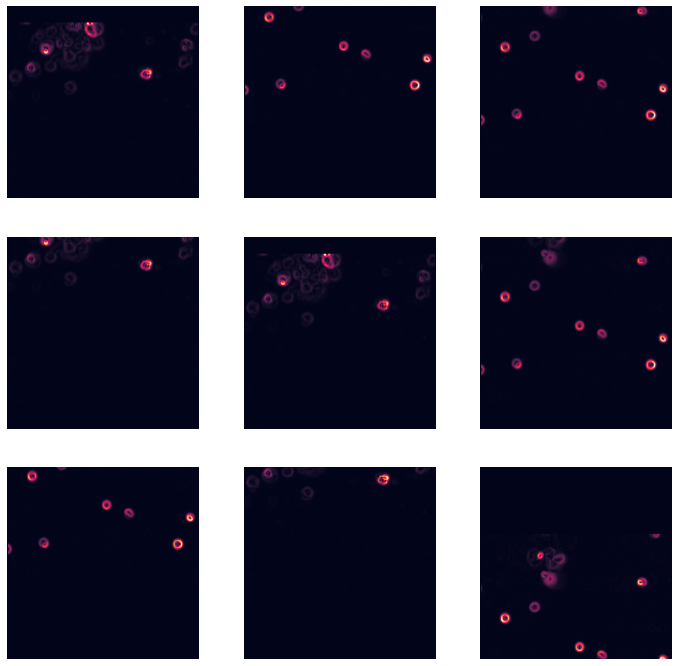

In [98]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
# load the image
img = load_img('bird.jpg')
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = x_train[0:2]
# create image data augmentation generator
datagen = ImageDataGenerator(height_shift_range=0.4)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
pyplot.figure(figsize=(12,12))
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    #image = batch[0].astype('uint16')
    # plot raw pixel data
    pyplot.imshow(reshape(batch[0], 192, 192))
    pyplot.grid("off")
    pyplot.axis("off")
# show the figure
pyplot.show()

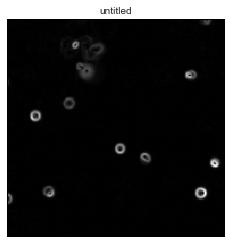

In [84]:
show_image(dataset[0])

### Helper functions for evaluating models

In [102]:
plt.rcParams.update({'axes.titlesize': 'medium'})

def run_evaluation(model, data=x_train, test=x_test, batch_size=48, epochs=30, visualise=False):
    # visualise feature maps
    if visualise:
        visualise_activations(model, data)
    
    # get model image predictions before training
    # @QUESTION: is this a good strategy?
    decoded_before = model.predict(data[21:22])
    test_decoded_before = model.predict(test[21:22])

    # fit model; get before/after weights (make sure there is a change)
    untrained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    loss = model.fit(data, data, epochs=epochs, batch_size=batch_size)
    trained_weights = [np.min(model.get_layer(index=1).get_weights()[0]), np.max(model.get_layer(index=1).get_weights()[0])]
    
    # plot the loss
    plt.figure()
    plt.plot(loss.history['loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    
    
    # show the difference in reconstruction
    decoded_imgs = model.predict(data[21:22]) # test on images it trained on
    untrained_decoded = model.predict(test[21:22]) # test images

    s=12
    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(data[21], w=imw, h=imh, c=c), "original training image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(decoded_imgs[0], w=imw, h=imh, c=c), "reconstructed - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(decoded_before[0], w=imw, h=imh, c=c), "reconstructed - before")

    fig = plt.figure(figsize=(s,s))
    fig.add_subplot(1, 3, 1)
    show_image(reshape(test[21], w=imw, h=imh, c=c), "original test image")
    fig.add_subplot(1, 3, 2)
    show_image(reshape(untrained_decoded[0], w=imw, h=imh, c=c), "reconstructed test - after")
    fig.add_subplot(1, 3, 3)
    show_image(reshape(test_decoded_before[0], w=imw, h=imh, c=c), "reconstructed test - before")
              
    # see if weights have changed
    print("Weight difference: {}".format(np.array(untrained_weights)-np.array(trained_weights)))

In [100]:
# credit: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md

def visualise_activations(model, images):
    idx = np.random.randint(2, len(images))
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[1:l]]
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    # Choose random image to predict for
    activations = activation_model.predict(images[idx-2:idx])

    layer_names = []
    for layer in model.layers[1:l]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                              :, :,
                                              col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 65535).astype('uint16')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                          row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                          scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='gray')

In [146]:
from keract import get_activations, display_activations

model = decoder
def activations(model, images):
    j = np.random.randint(2, len(images))
    l = len(model.layers)
    layer_outputs = [layer.output for layer in model.layers[-3:]]
    layer_names = [layer.name for layer in model.layers[-3:]]

    for idx, layer in enumerate(layer_outputs):
        activation_model = Model(inputs=model.input, outputs=layer_outputs)
        activation_model.compile(optimizer="nadam", loss="binary_crossentropy")
        activations = get_activations(activation_model, x_train[j-1:j], layer_names[idx])
        display_activations(activations, cmap="gray", save=False)

### Build autoencoder model

In [142]:
# build autoencoder for dataset

from keras.layers import Input, LeakyReLU, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(imw, imh, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), padding='same')(x)

In [188]:
# try model with strided convolutions rather than maxpooling

input_img = Input(shape=(imw, imh, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(64, (5, 5), strides=2, activation='relu',padding='same')(input_img)
x = Conv2D(32, (5, 5), strides=2, padding='same')(x)
x = Activation('sigmoid')(x)
x = Conv2D(16, (2, 2), strides=2, activation='relu', padding='same')(x)
encoded = Flatten()(x)
#encoded = x

x = Conv2D(16, (2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [201]:
input_img = Input(shape=(imw, imh, c))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(c, (3, 3), activation='sigmoid', padding='same')(x)

In [202]:
decoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


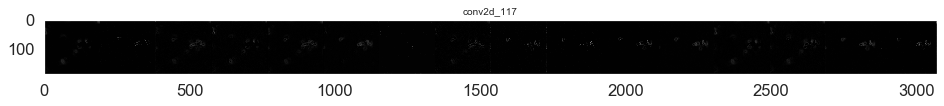

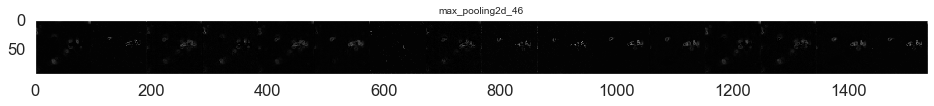

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

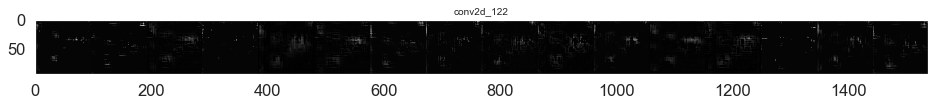

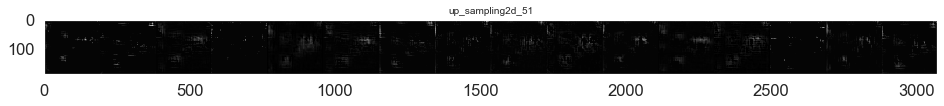

RuntimeError: libpng signaled error

<Figure size 1152x0 with 1 Axes>

In [209]:
visualise_activations(decoder, x_pair)

In [56]:
encoder = Model(input_img, decoder.get_layer(index=9).output)

In [45]:
decoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [47]:
decoder.fit(x_train[:100], x_train[:100], epochs=5, batch_size=50)

Epoch 1/5
100/100 [==============================] - 23s 235ms/step - loss: 3.7144e-08
Epoch 2/5
100/100 [==============================] - 29s 291ms/step - loss: 3.7144e-08
Epoch 3/5
100/100 [==============================] - 21s 207ms/step - loss: 3.7144e-08
Epoch 4/5
100/100 [==============================] - 28s 279ms/step - loss: 3.7144e-08
Epoch 5/5
100/100 [==============================] - 26s 256ms/step - loss: 3.7144e-08


In [203]:
encoded_pairs = encoder.predict(x_pair)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.7033083, -1.4512957, '0'),
  Text(-0.52070516, -5.2024746, '1'),
  Text(-1.1494772, 2.5460234, '2'),
  Text(-2.3225114, -1.5560582, '3')])

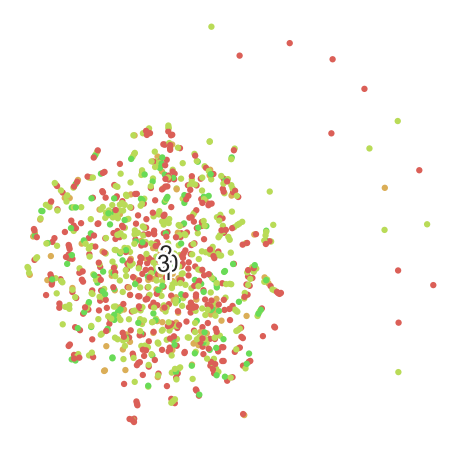

In [206]:
tsne = TSNE(perplexity=4, learning_rate=120, random_state=RS).fit_transform(encoded_pairs)
scatter(tsne, y_pair)

In [171]:
encoded_imgs = encoder.predict(x_train)

In [28]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(random_state=RS).fit_transform(encoded_imgs)

/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Leonore/Documents/Workspace/venv/ml/lib/python3.6/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(0.81069523, -0.08904408, '0'),
  Text(nan, nan, '1'),
  Text(0.91463053, -0.84218985, '2')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


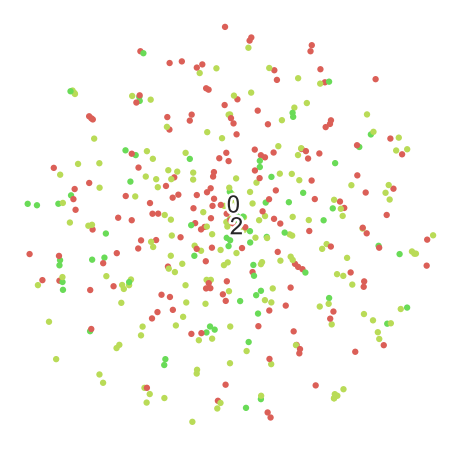

In [29]:
scatter(tsne, y_test)

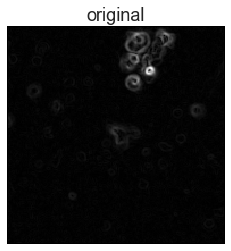

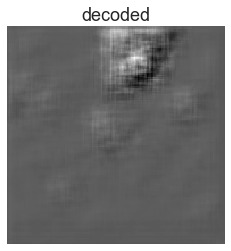

In [54]:
show_image(reshape(x_test[11], w=imw, h=imh), title="original")
show_image(reshape(decoded_imgs[11], w=imw, h=imh), title="decoded")
#show_image(reshape(decoded_mnist[0], w=image_width, h=image_height), title="decoded")
#show_image(reshape(decoded_mnist[5], w=32, h=32), title="decoded")

### TODO
* Tune autoencoder to get dimensionality reduction DONE
* Tune autoencoder to get good results!
* Calculate overlap
* Follow t-sne tutorial; read on parameters; adapt for the task
* Same for UMAP
* Fit_transform overlapped compressed images in t-sne, then umap
* Hope for the best

### Calculate overlap between images

In [178]:
encoder.output_shape

(None, 9216)

In [179]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, encoder.output_shape[1]), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        if labels[idx] != labels[idx+1]:
            raise("There is a label issue at %d" %idx)
        #o = reshape(np.abs(dcell-tcell))
        o = np.abs(dcell-tcell)
        overlaps[y] = o
        overlap_labels.append(labels[idx])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(encoded_imgs, y_train)
#overlap, _ = calculate_overlap(x_test, y_test)

### TSNE code on own dataset

In [186]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=12, learning_rate=200, random_state=RS).fit_transform(x_overlap)

(<Figure size 576x576 with 1 Axes>,
 [Text(1.9308816, 0.94870734, '0'),
  Text(-2.950614, -0.007576411, '1'),
  Text(0.5641454, 0.7514255, '2'),
  Text(-1.4550862, 1.4340439, '3')])

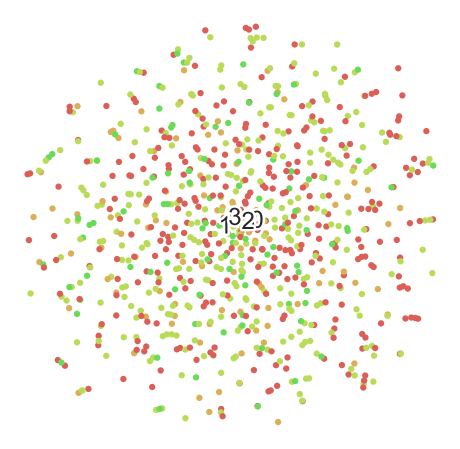

In [187]:
# after fixing overlap function

scatter(tsne, y_overlap)

In [51]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE(random_state=RS).fit_transform(x_overlap)

(<Figure size 576x576 with 1 Axes>,
 [Text(4.975341, -10.336546, '0'),
  Text(-12.279524, 24.514067, '1'),
  Text(4.2586923, -9.231358, '2'),
  Text(4.6639204, -9.599739, '3')])

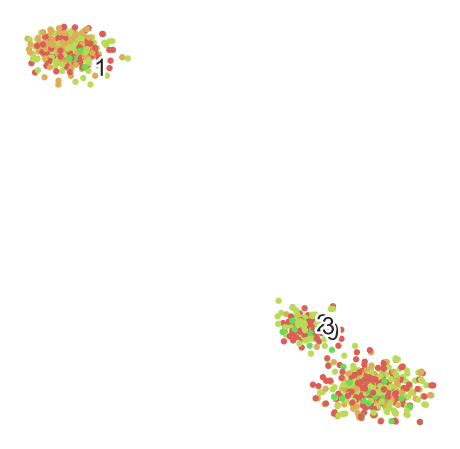

In [60]:
# before fixing overlap function
scatter(tsne, y_overlap)

In [25]:
x_dmso = np.reshape(x_)

(196, 200, 200, 1)

In [23]:
import umap.umap_ as umap
reducer = umap.UMAP()
embeddings = reducer.fit_transform(DMSO_dataset)

ValueError: Found array with dim 3. Estimator expected <= 2.

(<Figure size 576x576 with 1 Axes>,
 [Text(-2.2661724, 1.0799658, '0'),
  Text(12.14735, 0.79522675, '1'),
  Text(-2.1294107, 1.0460321, '2'),
  Text(-2.330204, 1.6459184, '3')])

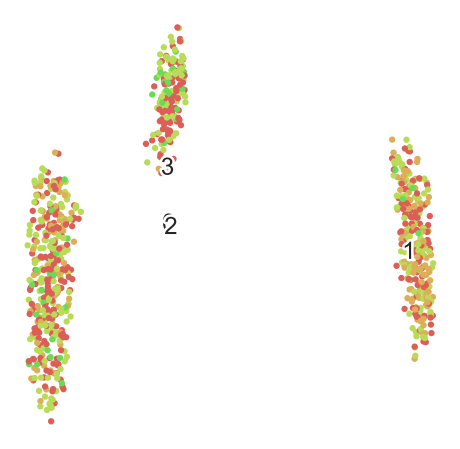

In [18]:
scatter(embeddings, y_overlap)

### View filters; code snippets

In [ ]:
num_classes

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))
filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [5]:
from skimage import filters

In [131]:
from skimage.exposure import adjust_gamma, rescale_intensity, equalize_adapthist

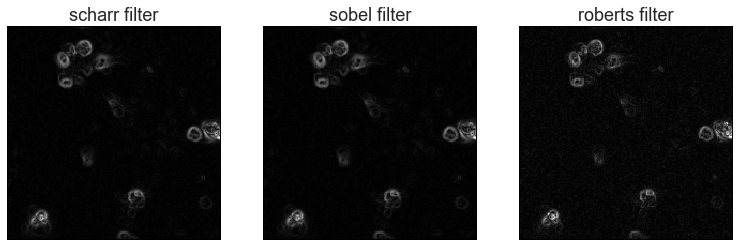

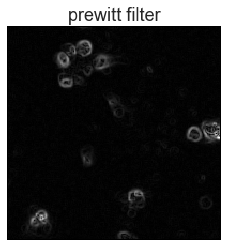

In [103]:
fig = plt.figure(figsize=(13,13))
fig.add_subplot(1,3,1)
plt.axis('off')
plt.title("scharr filter")
plt.imshow(filters.scharr(dataset[15]), cmap="gray")
fig.add_subplot(1,3,2)
plt.axis('off')
plt.title("sobel filter")
plt.imshow(filters.sobel(dataset[15]), cmap="gray")
fig.add_subplot(1,3,3)
plt.axis('off')
plt.title("roberts filter")
plt.imshow(filters.roberts(dataset[15]), cmap="gray")

fig = plt.figure(figsize=(13,13))
fig.add_subplot(1,3,1)
plt.axis('off')
plt.title("prewitt filter")
plt.imshow(filters.prewitt(dataset[15]), cmap="gray")

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1

### Run own code on MNIST dataset

In [7]:
import numpy as np
import pandas as pd

from keras.datasets import mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

RS = 20191458

Using TensorFlow backend.


In [36]:
from keras.datasets import mnist
(x_train, y_train), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [12]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [13]:
compressed_digits = encoder.predict(x_train)

In [15]:
x_sample, y_sample = compressed_digits[:1000], y_train[:1000]

In [16]:
digits_proj = TSNE(random_state=RS).fit_transform(x_sample)

(<Figure size 576x576 with 1 Axes>,
 [Text(-23.434824, -24.07652, '0'),
  Text(0.8921342, 36.784325, '1'),
  Text(-3.4372888, -14.56851, '2'),
  Text(-18.846968, -2.4877715, '3'),
  Text(24.522135, -7.741519, '4'),
  Text(-12.719883, 4.7274294, '5'),
  Text(2.67167, -32.721523, '6'),
  Text(25.147923, 17.10795, '7'),
  Text(-26.502972, 13.967726, '8'),
  Text(21.978443, 4.1691303, '9')])

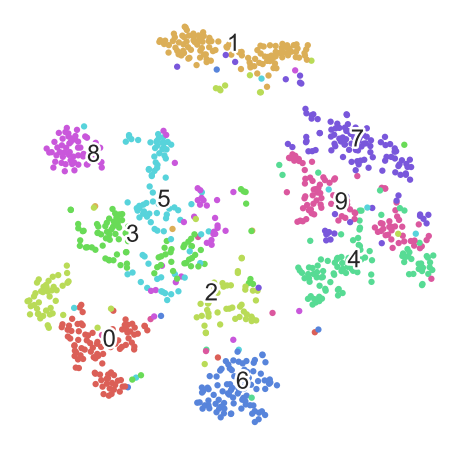

In [18]:
scatter(digits_proj, y_sample)

#### Tuning autoencoder
Testing CIFAR

In [13]:
from keras.datasets import cifar10

(x_cifar, y_cifar), (x_cifartest, y_cifartest) = cifar10.load_data()

   745472/170498071 [..............................] - ETA: 4:57:09

KeyboardInterrupt: 

In [ ]:
x_cifar = x_cifar.astype('float32')
x_cifartest = x_cifartest.astype('float32')
x_cifar /= 255.0
x_cifartest /= 255.0

In [14]:
from keras.layers import Input, Dense, Conv2D, Conv3D, MaxPooling2D, UpSampling2D, Flatten
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(imw, imh, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(32, (3, 3), strides=1, padding='same')(input_img)
#x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)
#x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
#x = LeakyReLU()(x)
#x = Conv2D(16, (3, 3), strides=1, padding='same')(x)
#x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
#x = Conv2D(32, (3, 3), strides=2, padding='same')(x)
x = LeakyReLU()(x)
x = MaxPooling2D((2,2))(x)
#x = Conv2D(16, (3, 3), strides=2, padding='same')(x)
#x = LeakyReLU()(x)
encoded = Flatten()(x)
#encoded = x

x = UpSampling2D()(x)
x = UpSampling2D()(x)
x = Conv2D(32, (3, 3), strides=1, padding='same')(x)
x = LeakyReLU()(x)
#x = LeakyReLU()(x)
x = UpSampling2D()(x)
decoded = Conv2D(1, (1, 1), strides=1, padding='same')(x)

In [15]:
decoder = Model(input_img, decoded)

In [17]:
nmodel = Model(input_img, decoded)

In [21]:
decoder.compile(optimizer="nadam", loss="binary_crossentropy")